<a href="https://colab.research.google.com/github/ShawnLiu119/Online-Order-Prediction-Pricing-Discrimination/blob/main/online_order_prediction_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
##### Import all necessity functions for Machine Learning #####
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as shc
import warnings
from collections import Counter
from functools import reduce
from itertools import chain
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, chi2, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE, ADASYN
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, SGDRegressor, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, silhouette_score
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

##### Download keras #####
!pip install keras

##### Import all necessity functions for Neural Network #####
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, GRU, RNN, Flatten, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, ELU, PReLU
from tensorflow.keras.activations import tanh, relu, sigmoid, softmax, swish
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam, Adamax, Nadam
from tensorflow.keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, hinge, MSE, MAE, Huber

##### Remove all warnings #####
import warnings
warnings.filterwarnings("ignore")

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
!pwd

/content/drive/My Drive/online_order_pred


In [77]:
%cd /content/drive/MyDrive/online_order_pred/

/content/drive/MyDrive/online_order_pred


In [78]:
##### Import the text file of this dataset #####
text_file1_   = pd.read_csv('realclass_t1.txt', delimiter   = '|', na_values = ['?', '??'])
text_file2_   = pd.read_csv('realClass_t2.txt', delimiter   = '|', na_values = ['?', '??'])
features = pd.read_csv('transact_class.txt', delimiter = '|', na_values = ['?', '??'])  #only features
with_label = pd.read_csv('transact_train.txt', delimiter = '|', na_values = ['?', '??'])  #including features & label

### EDA

In [79]:
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45068 entries, 0 to 45067
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sessionNo        45068 non-null  int64  
 1   startHour        45068 non-null  int64  
 2   startWeekday     45068 non-null  int64  
 3   duration         45068 non-null  float64
 4   cCount           45068 non-null  int64  
 5   cMinPrice        44742 non-null  float64
 6   cMaxPrice        44742 non-null  float64
 7   cSumPrice        44742 non-null  float64
 8   bCount           45068 non-null  int64  
 9   bMinPrice        44479 non-null  float64
 10  bMaxPrice        44479 non-null  float64
 11  bSumPrice        44479 non-null  float64
 12  bStep            24302 non-null  float64
 13  onlineStatus     27713 non-null  object 
 14  availability     27311 non-null  object 
 15  customerNo       27804 non-null  float64
 16  maxVal           27616 non-null  float64
 17  customerScor

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder
0,1,18,7,136.833,3,39.99,39.99,79.98,1,39.99,...,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
1,1,18,7,189.984,3,39.99,39.99,79.98,1,39.99,...,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
2,1,18,7,342.894,6,16.99,39.99,113.96,2,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
3,1,18,7,411.051,8,16.99,39.99,149.94,3,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
4,1,18,7,460.049,10,16.99,39.99,189.92,4,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0


In [80]:
##### Show the shape of each text file #####
print(f'realclass_t1.txt shape is {text_file1_.shape}')
print(f'realClass_t2.txt shape is {text_file2_.shape}')
print(f'transact_class.txt shape is {features.shape}')
print(f'transact_train.txt shape is {with_label.shape}')

realclass_t1.txt shape is (5111, 2)
realClass_t2.txt shape is (30000, 2)
transact_class.txt shape is (45068, 23)
transact_train.txt shape is (429013, 24)


In [81]:
with_label.isnull().sum()

sessionNo               0
startHour               0
startWeekday            0
duration                0
cCount                  0
cMinPrice            2765
cMaxPrice            2765
cSumPrice            2765
bCount                  0
bMinPrice            5130
bMaxPrice            5130
bSumPrice            5130
bStep              191333
onlineStatus       160379
availability       165255
customerNo         151098
maxVal             153740
customerScore      153740
accountLifetime    153740
payments           151098
age                151396
address            151098
lastOrder          151098
order                   0
dtype: int64

In [82]:
##explore target variable

with_label['order'].value_counts()

y    290030
n    138983
Name: order, dtype: int64

In [83]:
#map target variable to binary values

df_train = with_label.copy()

df_train['order'] = df_train['order'].map({'y': 1, 'n': 0})

df_train.head()


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [84]:
print('The categorical features of this dataset is given below\n')
print(list(df_train.dtypes[df_train.dtypes == 'object'].index))
print('-'*50)

The categorical features of this dataset is given below

['onlineStatus', 'availability']
--------------------------------------------------


In [85]:
df_train['availability'].value_counts()
#we may want to remove non-orderable data to remove the impact of object avaiabibility on subjective willingness to buy

completely orderable           253692
mainly orderable                 5756
completely not orderable         1491
mixed                            1284
completely not determinable      1017
mainly not orderable              320
mainly not determinable           198
Name: availability, dtype: int64

In [86]:
df_train['onlineStatus'].value_counts()

y    265625
n      3009
Name: onlineStatus, dtype: int64

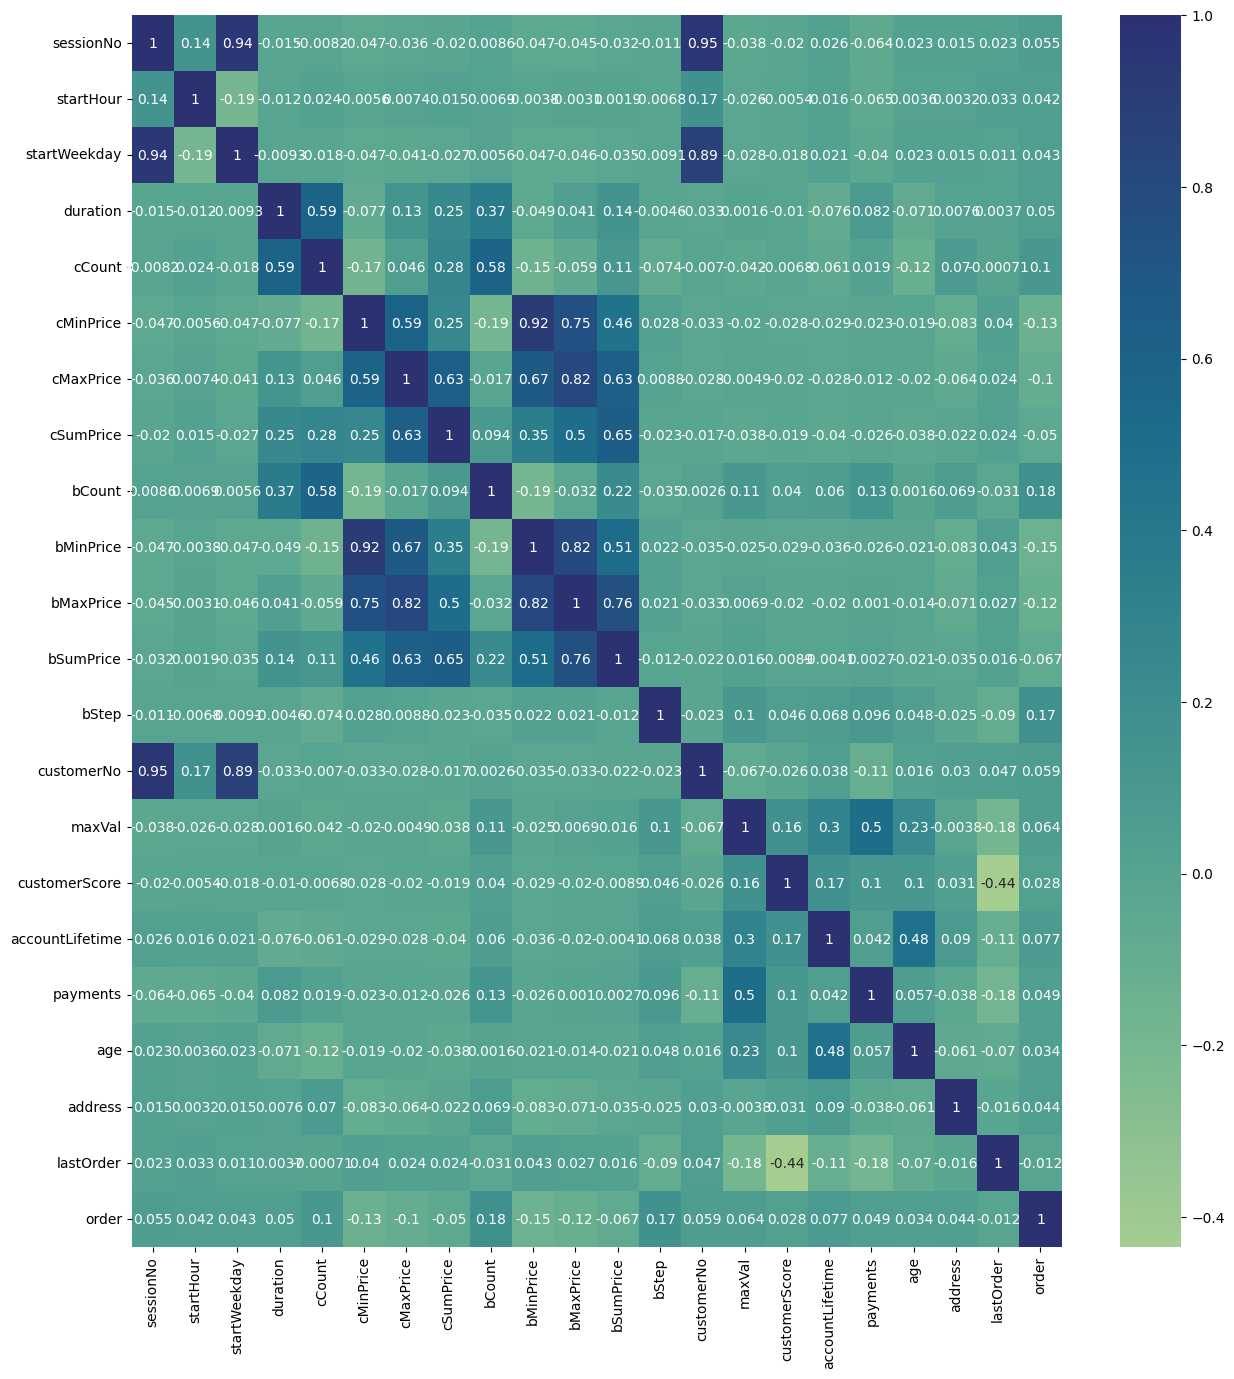

In [87]:
#explore colinearity
plt.figure(figsize = (15, 16))
sns.heatmap(df_train.corr(), cmap="crest", annot = True)
plt.show()

In [88]:
##colinearity

#sessionNO -- startWeekday -- customerNo (this seems just index to label customer, not meaningful except we want predict on customer-basis instead of per-visit basis)
#duration -- clickcount
#bMaxPrice -- bMinPrice -- cMaxPrice -- bMaxPrice

In [89]:
df_train.columns

Index(['sessionNo', 'startHour', 'startWeekday', 'duration', 'cCount',
       'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice',
       'bMaxPrice', 'bSumPrice', 'bStep', 'onlineStatus', 'availability',
       'customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments',
       'age', 'address', 'lastOrder', 'order'],
      dtype='object')

In [90]:
#one observation is that: The customers who do not have customerNo might be new customers who have not registered yet
df_train[df_train['customerNo'].isna()]['accountLifetime'].isnull().sum()

151098

In [91]:
df_train[df_train['customerNo'].isna()].head(100)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,2,6,5,26.235,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,2,6,5,71.200,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,2,6,5,94.469,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,22,6,5,3718.600,81,9.99,119.95,2292.44,8,9.99,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
195,22,6,5,3764.965,81,9.99,119.95,2292.44,8,9.99,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
196,22,6,5,3784.495,81,9.99,119.95,2292.44,8,9.99,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
197,23,6,5,0.000,1,6.99,6.99,6.99,1,6.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [92]:
df_exis = df_train[df_train['customerNo'].notna()]
df_new = df_train[df_train['customerNo'].isna()]

print(df_exis.shape) #existing customers
print(df_new.shape) #guest customers

(277915, 24)
(151098, 24)


In [93]:
#according to observation above
## 1. will drop sessionNO, customerNo, as they are less relevant
## 2. leave only "mainly orderable" and "completely orderable" within avaiability column

df_exis.drop(['customerNo'], axis = 1, inplace = True)
df_exis.drop(['sessionNo'], axis = 1, inplace = True)
df_ex_al = df_exis[df_exis['availability'].isin(['completely orderable','mainly orderable'])]
df_ex_al.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,...,onlineStatus,availability,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,...,y,completely orderable,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
2,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,...,y,completely orderable,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
10,6,5,310.967,11,9.99,29.99,109.95,2,9.99,29.99,...,y,completely orderable,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1
11,6,5,324.278,11,9.99,29.99,109.95,2,9.99,29.99,...,y,completely orderable,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1
12,6,5,341.613,11,9.99,29.99,109.95,2,9.99,29.99,...,y,completely orderable,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1


In [94]:
df_ex_al.drop(['availability'], axis = 1, inplace = True)
df_ex_al.describe()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
count,168341.000000,168341.000000,168341.000000,168341.000000,168172.000000,168172.000000,168172.000000,168341.000000,166576.000000,166576.000000,166576.000000,142007.000000,166597.000000,166597.000000,166597.000000,168341.000000,168147.000000,168341.000000,168341.000000,168341.000000
mean,14.653560,5.933154,1828.096674,27.796009,42.336493,130.925791,1109.262912,4.679276,52.080321,91.816374,190.787852,2.360215,2476.203053,483.810351,134.209344,15.467165,44.969556,1.724636,80.831853,0.820507
std,4.314951,0.786434,2477.415486,32.396325,121.254126,252.927723,2807.346156,4.572020,141.550087,178.114863,339.893276,1.335713,3048.066860,132.798735,109.169504,35.526940,11.967108,0.449271,115.708314,0.383766
min,0.000000,5.000000,0.062000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,17.000000,1.000000,3.000000,0.000000
25%,11.000000,5.000000,390.881000,6.000000,5.000000,29.990000,159.960000,2.000000,7.950000,19.990000,45.980000,1.000000,600.000000,481.000000,42.000000,3.000000,36.000000,1.000000,14.000000,1.000000
50%,15.000000,6.000000,994.661000,16.000000,9.990000,49.990000,424.920000,3.000000,12.990000,39.900000,94.940000,2.000000,1500.000000,519.000000,108.000000,8.000000,45.000000,2.000000,34.000000,1.000000
75%,18.000000,7.000000,2235.256000,37.000000,19.990000,99.990000,1069.200000,6.000000,29.990000,69.990000,199.990000,4.000000,4000.000000,554.000000,219.000000,15.000000,53.000000,2.000000,86.000000,1.000000
max,23.000000,7.000000,21553.323000,200.000000,2799.990000,6999.990000,76239.340000,108.000000,6999.990000,6999.990000,10429.830000,5.000000,50000.000000,638.000000,564.000000,868.000000,99.000000,3.000000,738.000000,1.000000


In [95]:
df_ex_al.isnull().sum()

startHour              0
startWeekday           0
duration               0
cCount                 0
cMinPrice            169
cMaxPrice            169
cSumPrice            169
bCount                 0
bMinPrice           1765
bMaxPrice           1765
bSumPrice           1765
bStep              26334
onlineStatus           0
maxVal              1744
customerScore       1744
accountLifetime     1744
payments               0
age                  194
address                0
lastOrder              0
order                  0
dtype: int64

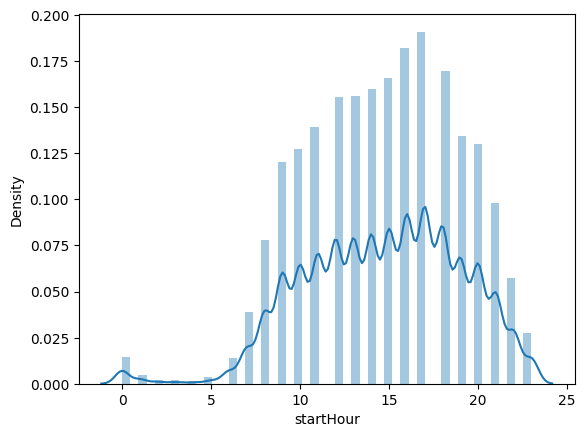

************************************************************************************************************************
The PLOT of distribution of startHour is given below.



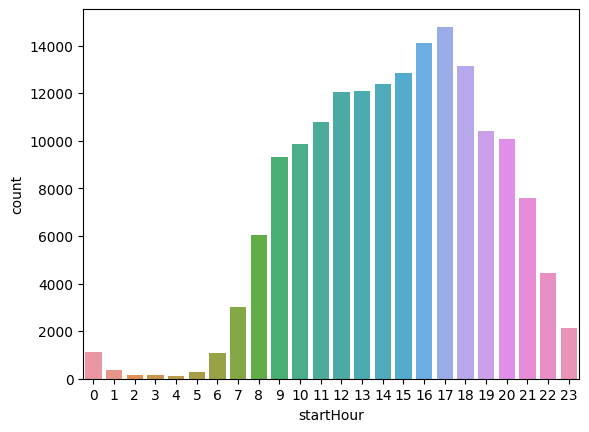

In [96]:
sns.distplot(df_ex_al.loc[:, 'startHour'])
plt.show()
print('*'*120)


# Plot the value counts of this feature
print('The PLOT of distribution of startHour is given below.\n')
sns.countplot(x=df_ex_al['startHour'])
plt.show()

## Feature Engineer & Cleaning

In [97]:
# Find the duplicates records in this dataset or not
if df_ex_al.duplicated().sum() > 0:
  print('There is duplicate values in this dataset. The number of duplicate value in this dataset is {}'.format(df_ex_al.duplicated().sum()))
else:
  print('No duplicate value in this dataset.')

No duplicate value in this dataset.


In [98]:
# df_avb.drop_duplicates(inplace = True)
# print("Duplicated value has been deleted.\n")

In [99]:
# Mean Imputation for missing value imputation
mean_imputation_column_ = ['cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice']

def mean_imputation(df, column_):
  df.loc[:, column_].fillna(df.loc[:, column_].mean(), inplace = True)
  print(f'{column_} is Done.\n')

for column_ in mean_imputation_column_:
  mean_imputation(df_ex_al, column_)

cMinPrice is Done.

cMaxPrice is Done.

cSumPrice is Done.

bMinPrice is Done.

bMaxPrice is Done.

bSumPrice is Done.



In [100]:
# Generate the function of random sample imputation #####
def random_sample_imputation(df_ex_al, variable):
  random_values_ = df_ex_al.loc[:, variable].dropna().sample(df_ex_al.loc[:, variable].isnull().sum(), random_state = 0).values
  random_index_  = df_ex_al.loc[:, variable].dropna().sample(df_ex_al.loc[:, variable].isnull().sum(), random_state = 0).index

  print(random_values_,'\n\n')
  print(random_index_, '\n\n')
  print('*'*120)

  ramdom_sample = df_ex_al.loc[:, variable].dropna().sample(df_ex_al.loc[:, variable].isnull().sum(), random_state = 0)
  ramdom_sample.index = df_ex_al[df_ex_al[variable].isnull()].index
  df_ex_al.loc[df_ex_al[variable].isnull(), variable] = ramdom_sample

random_sample_ = list(df_ex_al.isnull().sum()[df_ex_al.isnull().sum()>0].index)

for variable_ in random_sample_:
  random_sample_imputation(df_ex_al, variable_)
  print(f'{variable_} is done.\n')

[4. 3. 1. ... 5. 1. 1.] 


Int64Index([  8356,  28760, 114785,  73793,  23339, 115137,  55578,   5248,
            384640, 190565,
            ...
            109518, 324975, 165615, 289368, 234246, 220135,  89229, 358408,
            307777,   7480],
           dtype='int64', length=26334) 


************************************************************************************************************************
bStep is done.

[ 300. 1400. 1000. ...  600. 4000. 2700.] 


Int64Index([178283, 171068,  85369, 116742, 301317, 181050, 407660, 398213,
             76964,  30991,
            ...
            279318, 247564, 325644,  40519, 251298, 310652,  57202, 427374,
            257630, 263061],
           dtype='int64', length=1744) 


************************************************************************************************************************
maxVal is done.

[380. 464. 603. ...  70.  70. 552.] 


Int64Index([178283, 171068,  85369, 116742, 301317, 181050, 407660, 398213,
   

In [101]:
df_ex_al.isnull().sum()


startHour          0
startWeekday       0
duration           0
cCount             0
cMinPrice          0
cMaxPrice          0
cSumPrice          0
bCount             0
bMinPrice          0
bMaxPrice          0
bSumPrice          0
bStep              0
onlineStatus       0
maxVal             0
customerScore      0
accountLifetime    0
payments           0
age                0
address            0
lastOrder          0
order              0
dtype: int64

In [102]:
df_ex_al.shape

(168341, 21)

In [103]:
df_ex_al.columns

Index(['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice',
       'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice',
       'bSumPrice', 'bStep', 'onlineStatus', 'maxVal', 'customerScore',
       'accountLifetime', 'payments', 'age', 'address', 'lastOrder', 'order'],
      dtype='object')

In [104]:
y = df_ex_al['order']
x_train = df_ex_al.drop(['order'], axis = 1, inplace = False)
x_train.columns

Index(['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice',
       'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice',
       'bSumPrice', 'bStep', 'onlineStatus', 'maxVal', 'customerScore',
       'accountLifetime', 'payments', 'age', 'address', 'lastOrder'],
      dtype='object')

In [105]:
print(list(x_train.dtypes[x_train.dtypes == 'object'].index))

['onlineStatus']


In [262]:
# Handing the categorical data #####
x_dum = pd.get_dummies(data = x_train, drop_first = True)
x_dum.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,onlineStatus_y
1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
2,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,4.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
10,6,5,310.967,11,9.99,29.99,109.95,2,9.99,29.99,39.98,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1
11,6,5,324.278,11,9.99,29.99,109.95,2,9.99,29.99,39.98,4.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1
12,6,5,341.613,11,9.99,29.99,109.95,2,9.99,29.99,39.98,1.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,1


In [265]:
y.value_counts()

1    138125
0     30216
Name: order, dtype: int64

### Model Development

In [266]:
# Scaling the dataset using StandardScaler #####
standard_scaler_ = StandardScaler()
X_scaled = standard_scaler_.fit_transform(x_dum)

# ##### Train and test dataset #####
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, shuffle = True, random_state = 42)

In [267]:
print(X_test.shape)

(50503, 20)


In [109]:
ml_models_ = {'NB': GaussianNB(), 'BNB': BernoulliNB(), 'SGD': SGDClassifier(), 'MLP': MLPClassifier(), 'LR': LogisticRegression(),
              'Perceptron': Perceptron(), 'DT': DecisionTreeClassifier(),
              'RF': RandomForestClassifier(),'Adaboost': AdaBoostClassifier(), 'GB': GradientBoostingClassifier(), 'XGB': XGBClassifier(), 'LightGBM': LGBMClassifier()}

##### Run the model and check the perfprmance #####

performance_list_    = []

for key_, value_ in ml_models_.items():

  dataframe_dictonary_ = {}

  classifier_ = value_.fit(X_train, y_train)
  predicted_  = classifier_.predict(X_test)

  print('{} classifier is running:\n'.format(key_).upper())

  print("accuracy score  = ".title(), accuracy_score(predicted_, y_test))
  dataframe_dictonary_['accuracy score'.upper()] = accuracy_score(predicted_, y_test)

  print("Precision score = ".title(), precision_score(predicted_, y_test))
  dataframe_dictonary_['Precision score'.upper()] = precision_score(predicted_, y_test)

  print("recall score    = ".title(), recall_score(predicted_, y_test))
  dataframe_dictonary_['recall score'.upper()] = recall_score(predicted_, y_test)

  print("f1_score        = ".title(), f1_score(predicted_, y_test))
  dataframe_dictonary_['f1_score '.upper()] = f1_score(predicted_, y_test)

  print('*'*40,'\n')

  ##### Append this into performance list #####
  performance_list_.append(pd.DataFrame(dataframe_dictonary_, index = [key_.upper()]))

NB CLASSIFIER IS RUNNING:

Accuracy Score  =  0.7945468586024592
Precision Score =  0.9332963293674735
Recall Score    =  0.8355406719239494
F1_Score        =  0.8817172431089122
**************************************** 

BNB CLASSIFIER IS RUNNING:

Accuracy Score  =  0.7779933865314932
Precision Score =  0.8999203610299974
Recall Score    =  0.8407169428474806
F1_Score        =  0.8693118239462888
**************************************** 

SGD CLASSIFIER IS RUNNING:

Accuracy Score  =  0.8199908916302002
Precision Score =  0.9962835147332094
Recall Score    =  0.8220430107526882
F1_Score        =  0.9008149950358401
**************************************** 

MLP CLASSIFIER IS RUNNING:

Accuracy Score  =  0.8525236124586658
Precision Score =  0.9663344354079687
Recall Score    =  0.8686842390714828
F1_Score        =  0.9149111182196225
**************************************** 

LR CLASSIFIER IS RUNNING:

Accuracy Score  =  0.8212185414727838
Precision Score =  0.9967179091150421
Recall

In [110]:
# Show the performance of Ml algorithms in the DataFrame format #####
pd.concat(performance_list_)

,ACCURACY SCORE,PRECISION SCORE,RECALL SCORE,F1_SCORE
NB,0.794547,0.933296,0.835541,0.881717
BNB,0.777993,0.899920,0.840717,0.869312
SGD,0.819991,0.996284,0.822043,0.900815
MLP,0.852524,0.966334,0.868684,0.914911
LR,0.821219,0.996718,0.822827,0.901463
PERCEPTRON,0.696374,0.772450,0.844249,0.806755
DT,0.946756,0.968144,0.967001,0.967572
RF,0.974101,0.999348,0.969994,0.984452
ADABOOST,0.829475,0.989502,0.833730,0.904962
GB,0.834960,0.995994,0.834769,0.908283


In [111]:
#Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction.
#Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

#top 3 based on F1 score are XGB, RF, LGBM
# Using StackingClassifier to evaluate the model with CV = 10
estimators_ = [
    ('RF', RandomForestClassifier()),
    ('XGB', XGBClassifier()),
    ('LightGBM', LGBMClassifier())
]

##### Fit the model and find the performance #####

StackingClassifier_ = StackingClassifier(estimators = estimators_, final_estimator = RandomForestClassifier(), cv = 10)
StackingClassifier_.fit(X_train, y_train)

predicted_ = StackingClassifier_.predict(X_test)

print("accuracy score  = ".title(), accuracy_score(predicted_, y_test))
print("Precision score = ".title(), precision_score(predicted_, y_test))
print("recall score    = ".title(), recall_score(predicted_, y_test))
print("f1_score        = ".title(), f1_score(predicted_, y_test))

[LightGBM] [Info] Number of positive: 96688, number of negative: 21150
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 117838, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.820516 -> initscore=1.519849
[LightGBM] [Info] Start training from score 1.519849
[LightGBM] [Info] Number of positive: 87019, number of negative: 19035
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3222
[LightGBM] [Info] Number of data points in the train set: 106054, number of used features: 20
[LightGBM] [

In [ ]:
# Use ensemble voting method to find out the result
# voting (you need to provide weight for each classifier or equal)

# In voting, user-specified weights are used to combine the classifiers whereas stacking performs this aggregation by using a blender/meta classifier.
# https://www.linkedin.com/pulse/comparing-voting-stacking-optimal-pipelines-python-subrata-chatterjee/

In [115]:
print(classification_report(y_test, predicted_))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      9066
           1       0.98      0.99      0.99     41437

    accuracy                           0.98     50503
   macro avg       0.97      0.96      0.96     50503
weighted avg       0.98      0.98      0.98     50503



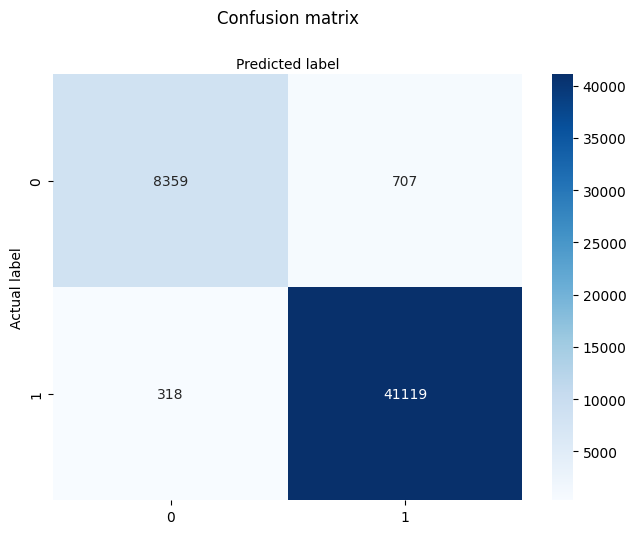

In [116]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, predicted_)
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Feature Importance Extraction & Tuning

In [117]:
PCA_ = PCA(n_components = None)
##### PCA result is given below ####
PCA_.fit_transform(X_scaled)

array([[-1.48053837e-01, -1.53888696e+00, -2.01334724e+00, ...,
        -9.00978802e-02, -8.40823520e-03, -2.87232383e-02],
       [-1.35010409e-01, -1.61287465e+00, -1.79163957e+00, ...,
        -6.85380815e-02, -1.27607767e-02, -2.52036046e-02],
       [-7.99567355e-01, -1.20804921e+00,  7.36311295e-01, ...,
         9.12507905e-02,  1.84647065e-02, -1.45819116e-02],
       ...,
       [-9.26288504e-01, -5.81484765e-01, -6.62483019e-01, ...,
         1.26621001e-01,  1.15038275e-03, -1.94911548e-02],
       [ 1.00425918e+00, -8.53694206e-01, -6.47870031e-01, ...,
         9.51892344e-02, -5.33245438e-01,  3.64290446e-01],
       [-9.47541224e-01, -1.39951154e+00, -8.21992541e-01, ...,
        -4.69793884e-02, -6.55489343e-03, -4.03290480e-03]])

cumsum of numpy is [0.20330533 0.11564355 0.10527824 0.06361503 0.05970826 0.05862372
 0.05063983 0.04876904 0.04762641 0.04069077 0.03801187 0.03514596
 0.02805771 0.02583586 0.02130397 0.02107378 0.01503767 0.0126757
 0.00540167 0.00355562] 

************************************************************************************************************************


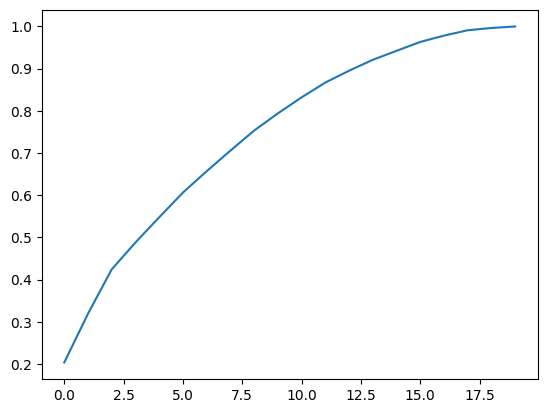

In [118]:
##### Find out 90% variance of PCA #####
print('cumsum of numpy is {}'.format(PCA_.explained_variance_ratio_),'\n')
print('*'*120)
plt.plot(np.cumsum(PCA_.explained_variance_ratio_))
plt.show()

In [120]:
##### PCA performed used with number of components = 12 ####
PCA_ = PCA(n_components = 12)
X_new_scaled_ = PCA_.fit_transform(X_scaled)
X_new_scaled_ = pd.DataFrame(X_new_scaled_, index = [y.index])
X_new_scaled_.head()

,0,1,2,3,4,5,6,7,8,9,10,11
1,-0.148054,-1.538887,-2.013347,0.608520,1.977979,-0.179046,0.357662,-0.955963,0.210571,-1.996553,0.291827,0.812706
2,-0.135010,-1.612875,-1.791640,0.838119,2.143200,-0.076609,0.951186,-0.580240,-1.045734,-1.985052,0.237767,0.911941
10,-0.799567,-1.208049,0.736311,0.135519,0.374326,-0.405100,0.708174,-1.211210,-0.371705,-2.171875,0.071920,0.804621
11,-0.793056,-1.245176,0.847167,0.250309,0.456915,-0.353875,1.004915,-1.023326,-0.999833,-2.166087,0.044904,0.854388
12,-0.811716,-1.122317,0.514438,-0.093208,0.210947,-0.508101,0.116475,-1.588942,0.882464,-2.186722,0.124658,0.692232


In [123]:
 StackingClassifier_.final_estimator_

RandomForestClassifier()

In [268]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

In [269]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [270]:
from sklearn.inspection import permutation_importance
#Permutation feature importance overcomes limitations of the impurity-based feature importance:
#they do not have a bias toward high-cardinality features and can be computed on a left-out test set.
import time

feature_names = [x_dum.columns[i] for i in range(x_dum.shape[1])]
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")



Elapsed time to compute the importances: 236.257 seconds


<Axes: >

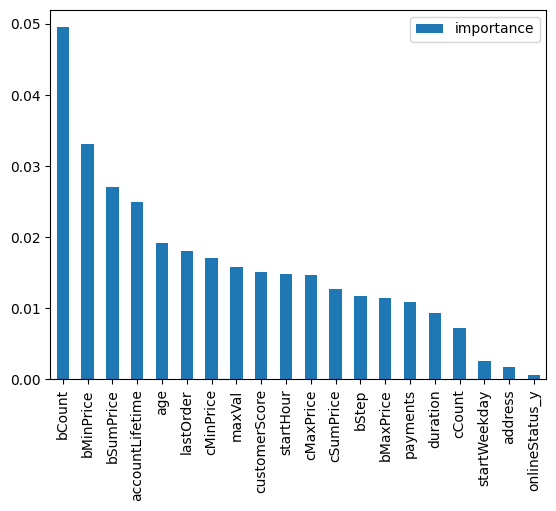

In [271]:
forest_importances = pd.DataFrame(result.importances_mean, index=feature_names)
forest_importances.rename(columns={0:'importance'}, inplace=True )

my_cmap = plt.get_cmap("viridis")

#plot grapha
forest_importances.sort_values(by='importance', ascending=False).plot.bar()



### Partial Dependence Plot
how about increase price and see how that change the total revenue?

In [214]:
def level_int (column, intervals):
  max = x_dum[column].max()
  min = x_dum[column].min()
  interval = (max - min)/intervals
  levels = []
  for i in range(intervals):
    levels.append(int(min + i*interval))
  return levels

In [ ]:
levels = level_int('bMinPrice', 20)

pred_df = pd.DataFrame(index=levels, columns=range(x_dum.shape[0]))
for i in levels:
    tmp = x_dum.copy()
    tmp['bSumPrice'] = i
    # tmp = standard_scaler_.fit_transform(tmp) if we replace the feature value as same, and standscaler will return the same result
    predictions = rf.predict_proba(tmp)
    print(i)
    print([x[1] for x in predictions])
    pred_df.loc[[i],:] = [x[1] for x in predictions]
pdp_values = pred_df.mean(axis=1)[1:]
pdp_values

In [190]:
plt.plot(levels[1:], pdp_values, color="blue", marker='o')
plt.ylim(0,0.04)
plt.xticks(levels[1:])
plt.xlabel('bMinPrice')
plt.ylabel('Order Place Probability')
plt.show()

168341

In [223]:
!pip install pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.7 MB/s eta 0:00:00


obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

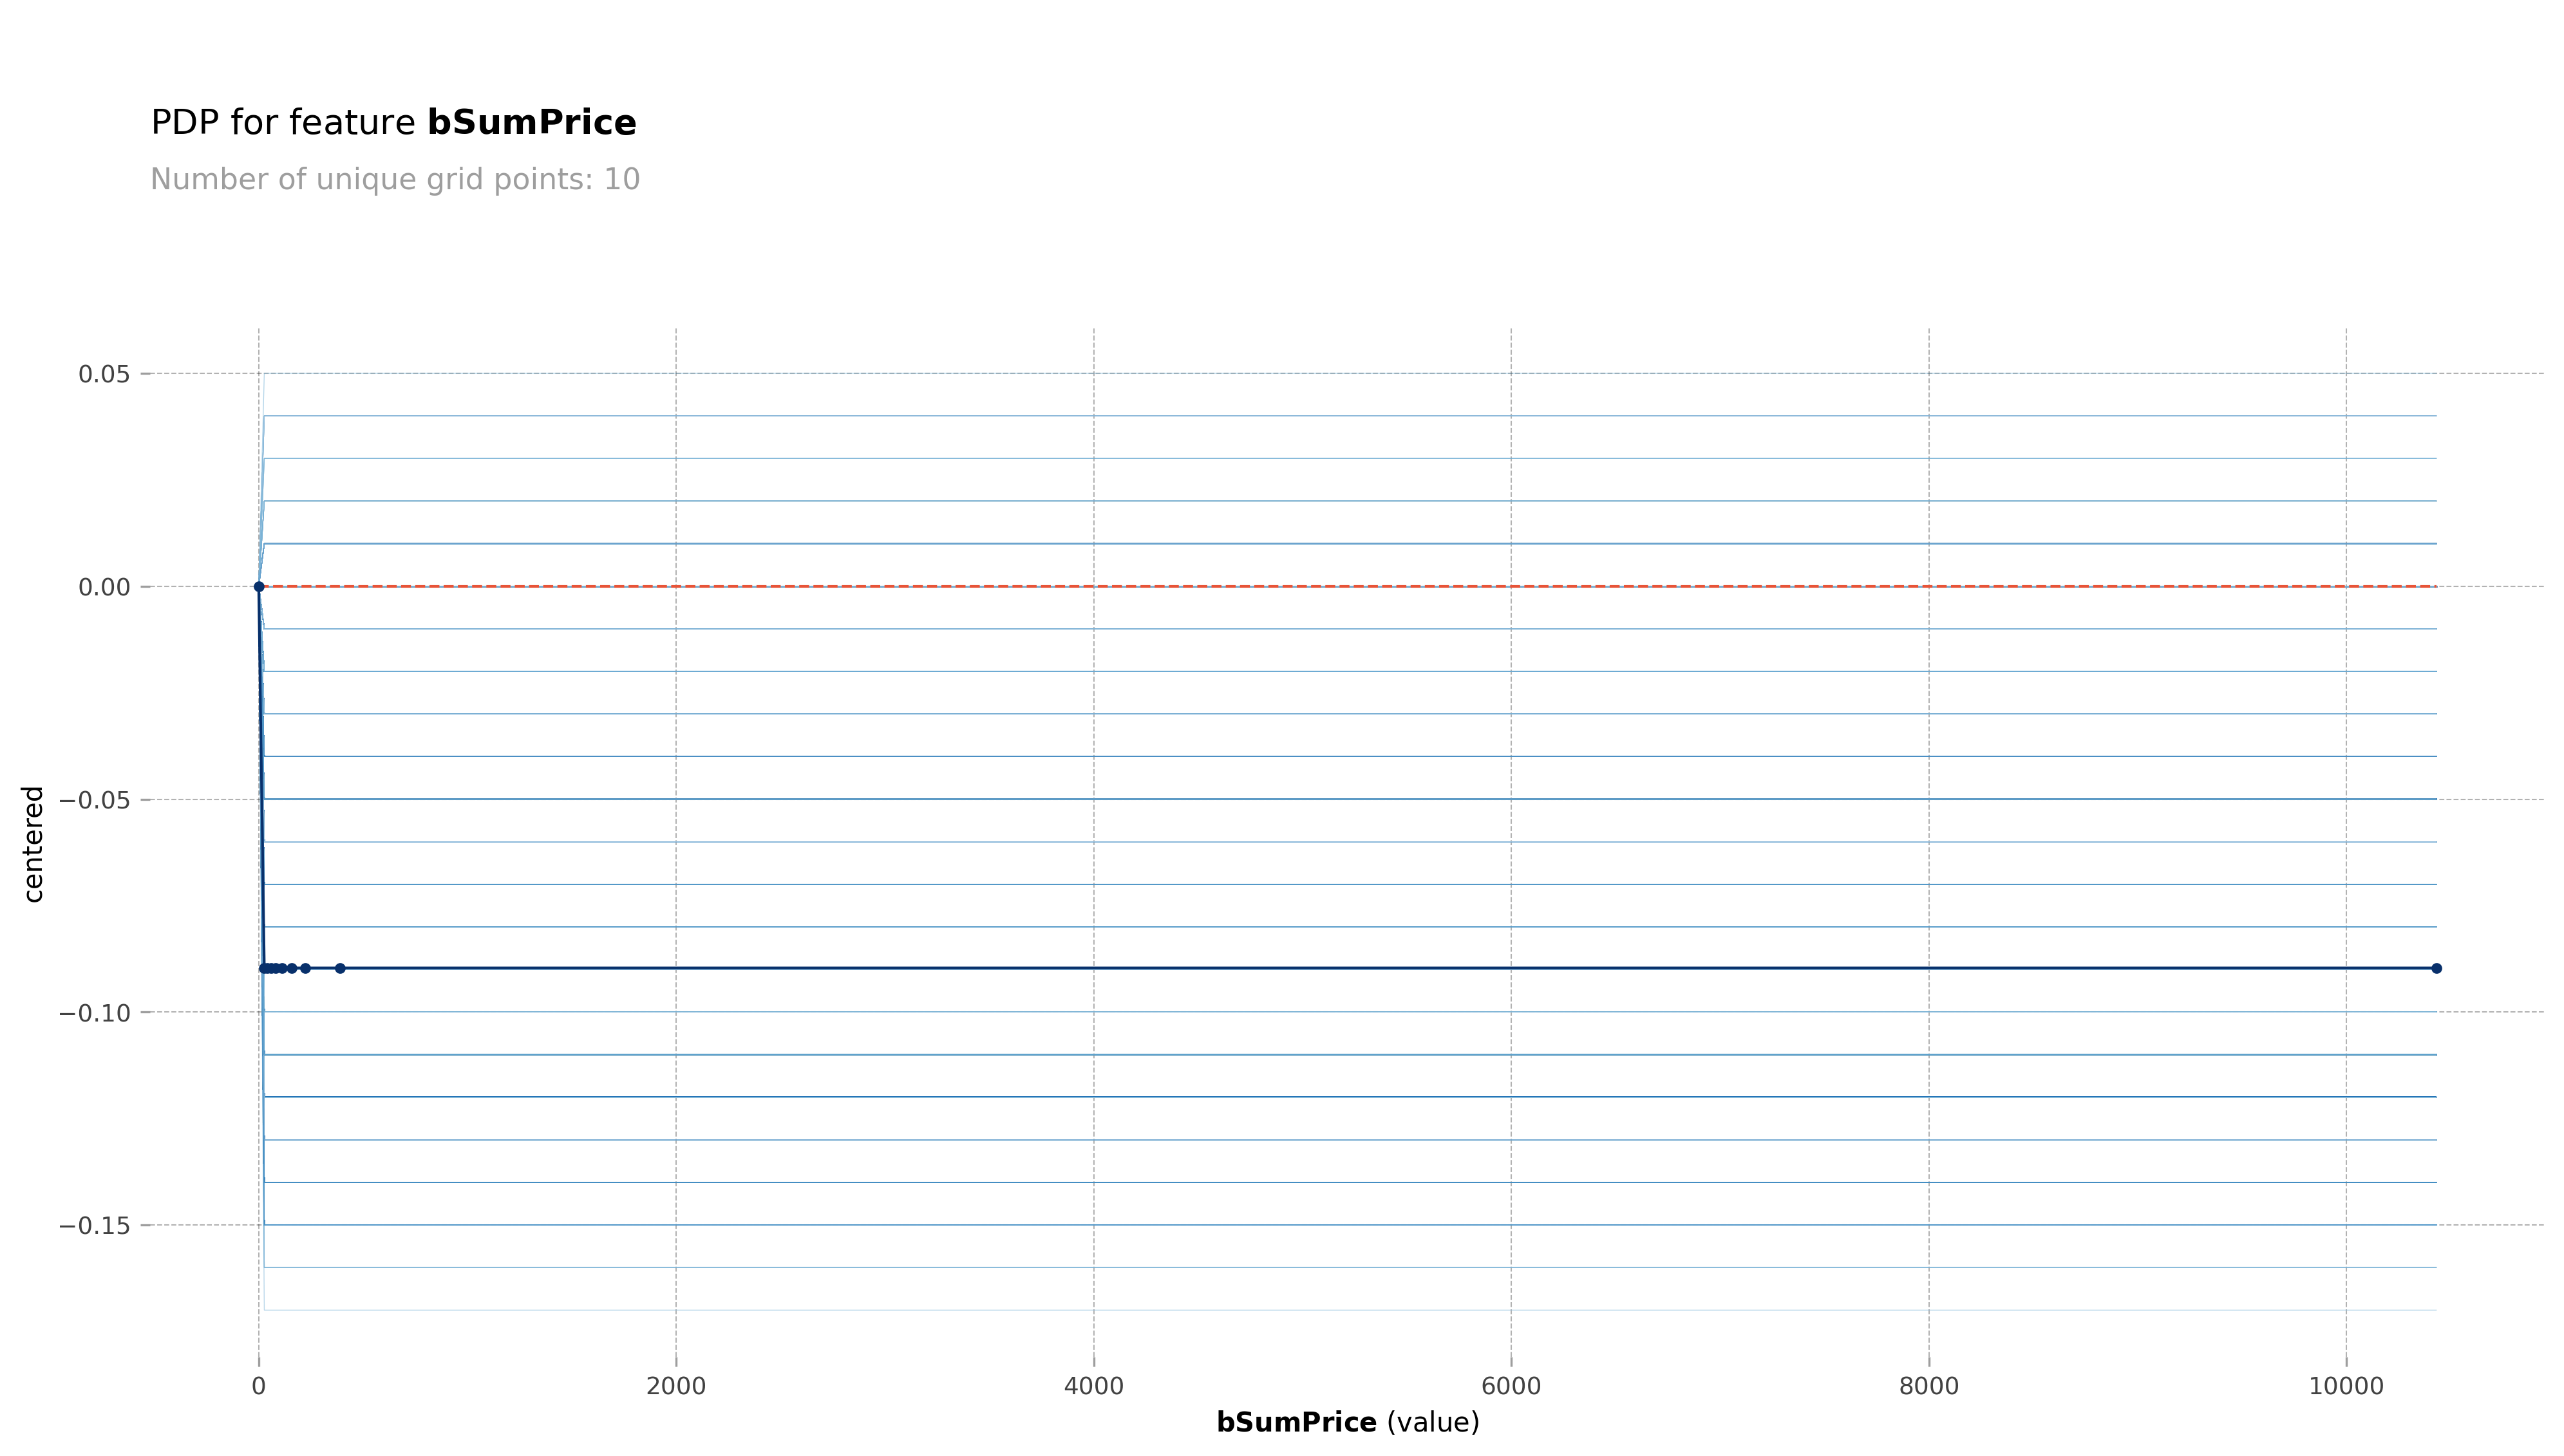

In [253]:
from pdpbox import pdp, info_plots

pdp_bMinPrice = pdp.PDPIsolate( model=rf, df=x_dum, model_features=x_dum.columns,
                               feature='bSumPrice', feature_name='bSumPrice')

#PDP Plot
fig, axes = pdp_bMinPrice.plot(engine='matplotlib', plot_lines=True)


In [ ]:
#assumption:
#1. bMinPrices are mostly what most customers pay
#2. scenarios
#    (1)all bMinPrice inflated by x%
#    (2)bMinPrice inflated to specific customer segment

In [274]:
df_test = pd.DataFrame(X_test)
df_test.columns = x_dum.columns
df_test


,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,onlineStatus_y
0,0.775547,1.356565,-0.581026,-0.364117,-0.266901,0.668767,-0.112057,0.507594,-0.298925,1.174940,0.988277,0.479980,0.728547,0.987713,2.287446,0.155737,1.172238,-1.612920,-0.646730,0.074975
1,1.007300,-1.186566,0.192317,3.556093,-0.308075,-0.201487,0.383220,-0.586018,-0.334364,-0.066748,-0.312914,0.479980,-0.352991,-0.043567,-0.697773,-0.435366,0.253223,0.612914,-0.543021,0.074975
2,1.007300,-1.186566,-0.016756,0.376710,-0.316409,-0.359714,-0.164531,0.507594,-0.341537,-0.292510,-0.268726,-1.017099,-0.058026,0.528530,-0.661145,-0.182036,-0.916433,0.612914,-0.171396,0.074975
3,0.543794,-1.186566,-0.287889,-0.148042,-0.101875,-0.122373,-0.003412,-0.367295,-0.014845,0.046132,0.175040,-0.268559,0.105843,0.528530,-0.203289,-0.153888,-0.498699,0.612914,-0.603518,0.074975
4,1.007300,0.085000,-0.480204,-0.178910,-0.283404,-0.399271,-0.284199,-0.148573,-0.313129,-0.348950,-0.345536,-0.268559,-0.615182,0.626388,-1.009115,-0.379070,-1.083527,0.612914,-0.413384,0.074975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50498,1.007300,0.085000,0.040425,-0.672795,-0.266901,-0.379493,-0.354023,0.070150,-0.277619,-0.320730,-0.251039,0.479980,-0.516860,0.633916,0.071424,-0.407218,1.422878,0.612914,-0.664015,0.074975
50499,-0.383218,1.356565,-0.261077,-0.240646,-0.283404,-0.466518,-0.330890,0.070150,-0.313129,-0.444899,-0.407677,0.479980,-0.352991,0.197316,-0.661145,0.662396,-0.164511,0.612914,-0.352887,0.074975
50500,1.239053,-1.186566,-0.672639,-0.796266,2.125979,0.668767,-0.181502,-0.804740,1.760651,1.174940,0.322982,1.977059,-0.221895,0.167205,-0.358960,-0.294627,0.336770,0.612914,-0.361530,0.074975
50501,1.702560,0.085000,-0.110529,-0.302381,-0.299906,-0.339936,-0.290750,0.726317,-0.327333,-0.264290,-0.163404,-1.017099,-0.484086,0.031709,-0.551260,0.155737,-0.832886,-1.612920,-0.586233,0.074975


In [276]:
def test_gen (df, column, delta):
  df_test = df.copy()
  df_test[column] = df_test[column] * (1 + delta)
  return df_test

In [278]:
df_p5 = test_gen(df_test, 'bMinPrice', 0.05)
df_p10 = test_gen(df_test, 'bMinPrice', 0.1)
df_p20 = test_gen(df_test, 'bMinPrice', 0.2)
df_n5 = test_gen(df_test, 'bMinPrice', -0.05)
df_n10 = test_gen(df_test, 'bMinPrice', -0.1)
df_n20 = test_gen(df_test, 'bMinPrice', -0.2)

In [284]:
pred_p5 = rf.predict(df_p5)
pred_p10 = rf.predict(df_p10)
pred_p20 = rf.predict(df_p20)
pred_n5 = rf.predict(df_n5)
pred_n10 = rf.predict(df_n10)
pred_n20 = rf.predict(df_n20)
pred_0 = rf.predict(df_test)

In [294]:
#reverse back to intial value
x_real = standard_scaler_.inverse_transform(df_test)
df_real = pd.DataFrame(x_real, columns=x_dum.columns)
df_real

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,onlineStatus_y
0,18.0,7.0,388.659,16.0,9.99,299.99,794.84,7.0,9.99,299.99,524.93,3.0,4700.0,615.0,384.0,21.0,59.0,1.0,6.0,1.0
1,19.0,5.0,2304.544,143.0,5.00,79.99,2184.55,2.0,5.00,79.99,84.99,3.0,1400.0,478.0,58.0,0.0,48.0,2.0,18.0,1.0
2,19.0,5.0,1786.585,40.0,3.99,39.99,647.60,7.0,3.99,39.99,99.93,1.0,2300.0,554.0,62.0,9.0,34.0,2.0,61.0,1.0
3,17.0,5.0,1114.878,23.0,29.99,99.99,1099.69,3.0,49.99,99.99,249.97,2.0,2800.0,554.0,112.0,10.0,39.0,2.0,11.0,1.0
4,19.0,6.0,638.436,22.0,7.99,29.99,311.82,4.0,7.99,29.99,73.96,2.0,600.0,567.0,24.0,2.0,32.0,2.0,33.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50498,19.0,6.0,1928.246,6.0,9.99,34.99,115.90,5.0,12.99,34.99,105.91,3.0,900.0,568.0,142.0,1.0,62.0,2.0,4.0,1.0
50499,13.0,7.0,1181.302,20.0,7.99,12.99,180.81,5.0,7.99,12.99,52.95,3.0,1400.0,510.0,62.0,39.0,43.0,2.0,40.0,1.0
50500,20.0,5.0,161.696,2.0,299.99,299.99,599.98,1.0,299.99,299.99,299.99,5.0,1800.0,506.0,95.0,5.0,49.0,2.0,39.0,1.0
50501,22.0,6.0,1554.270,18.0,5.99,44.99,293.44,8.0,5.99,44.99,135.54,1.0,1000.0,488.0,74.0,21.0,35.0,1.0,13.0,1.0


In [298]:
delta = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2]
pred = [pred_n20, pred_n10, pred_n5, pred_0, pred_p5, pred_p10, pred_p20]

sales_dic = {}
for i in range(len(delta)):
  price = df_real['bMinPrice'] * (1+delta[i])
  sales_dic[delta[i]] = np.dot(price, pred[i])

sales_dic

{-0.2: 1491742.951540464,
 -0.1: 1669051.8174830736,
 -0.05: 1759766.319454323,
 0: 1853485.1194255883,
 0.05: 1946940.2918969146,
 0.1: 2043422.9193681881,
 0.2: 2230458.467310717}

In [299]:
order_dic = {}
for i in range(len(delta)):
  order_dic[delta[i]] = np.sum(pred[i])

order_dic

{-0.2: 43136,
 -0.1: 42846,
 -0.05: 42756,
 0: 42676,
 0.05: 42774,
 0.1: 42871,
 0.2: 43062}

In [325]:
df_rev_order = pd.DataFrame({'revenue':pd.Series(sales_dic),'order':pd.Series(order_dic)})

df_plot = df_rev_order.reset_index()
df_plot['index'] = df_plot['index'].astype('string')
df_plot

,index,revenue,order
0,-0.2,1.491743e+06,43136
1,-0.1,1.669052e+06,42846
2,-0.05,1.759766e+06,42756
3,0.0,1.853485e+06,42676
4,0.05,1.946940e+06,42774
5,0.1,2.043423e+06,42871
6,0.2,2.230458e+06,43062


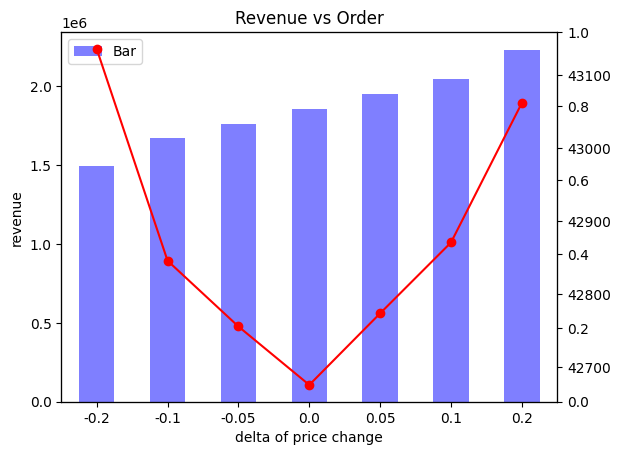

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()

df_plot.plot(kind='bar', x='index', y='revenue', ax=ax, color='b', alpha=0.5, label='Bar')
plt.twinx()
# Plot a line chart
df_plot.plot(kind='line', x='index', y='order', ax=ax, color='r', marker='o', label='Line', secondary_y = True)

# Add a legend
ax.legend()

ax.set_xlabel('delta of price change')
ax.set_ylabel('revenue')
ax.set_title('Revenue vs Order')

# Show the plot
plt.show()

